### TGS Salt identification challenge    


##### Starting points and initial ideas are thanks to [The Way of the Geophysicist](https://the-geophysicist.com/) and  https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277 

Lots of libraries    

In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
### CV2 is a powerful library for working with images in Python - , including image loading and display, image manipulation, and image filtering.
import cv2

### tqdm - instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable):
from tqdm import tqdm_notebook, tnrange
### itertools — Functions creating iterators for efficient looping:
from itertools import chain
### scikit-image is an image processing Python package that works with numpy arrays:
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
## from keras.layers.core import Lambda
## from keras.layers.convolutional import Conv2D, Conv2DTranspose
## from keras.layers.pooling import MaxPooling2D
## from keras.layers.merge import concatenate
from keras.layers import Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
# Parameters - model image width, height, channels and dir paths 
im_width = 128
im_height = 128
im_chan = 1
path_train = './train'
path_test = './test'

# Data Exploration
Vizualistion of 5 different random pics ....    

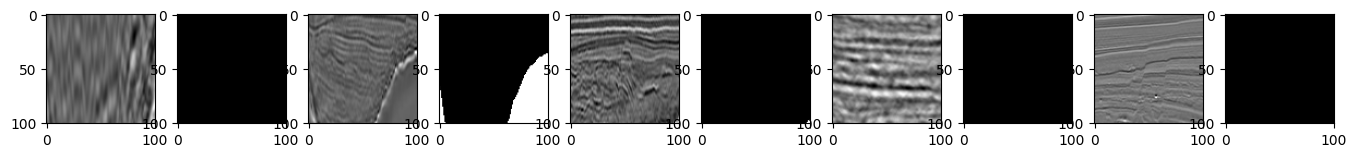

In [4]:
### Pick 5 varied image files
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
## The enumerate () method adds a counter to an iterable and returns it in the form of an enumerating object
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('./train/images/' + img_name + '.png')
    img_mask = load_img('./train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [5]:
train_ids = next(os.walk(path_train+"/images"))[2]
test_ids = next(os.walk(path_test+"/images"))[2]

In [6]:
train_ids.pop(4000)

'Thumbs.db'

In [7]:
print(train_ids[3999])
len(train_ids)

fff987cdb3.png


4000

In [8]:
print(test_ids[4000])
len(test_ids)

39c47a3f54.png


18000

##### Import of the images ...... 

In [9]:
### set up X_train as zero'ed numpt arrays with (4000, 101, 101, 3) in size. 
### Use dtype=np.uint8 
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=bool)

### Get and resize train images and masks
print('Getting and resizing train images and masks ... ')
### sys. stdout. flush() is used to force the program to flush the output buffer
sys.stdout.flush()
### This is a loop that iterates through a list of train_ids with progress tracking provided by tqdm_notebook. n is an index, and id_ is the current element from train_ids.
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)         ###  Loads an image located at the path - load_img is a Keras function used to load image in PIL format. PIL format - Python Imaging Library. 
    x = img_to_array(img)[:,:,1]                    ### This converts the loaded image img(PIL) into a NumPy array using img_to_array, and it selects the second channel (index 1) from the array.
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)          ### function resizes the image data to a new size of 128x128 pixels with a single channel
    X_train[n] = x                                                              ### Set the X_train data to the resized input images, x 
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]                ### Repeat the image input to numpy for the masks
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)          ### Set the maks as the Y_train target. 

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\tanopsgeo\AppData\Local\Temp\ipykernel_20464\1571549623.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/4000 [00:00<?, ?it/s]

Done!


In [10]:
X_train.shape

(4000, 128, 128, 1)

In [11]:
Y_train.shape

(4000, 128, 128, 1)

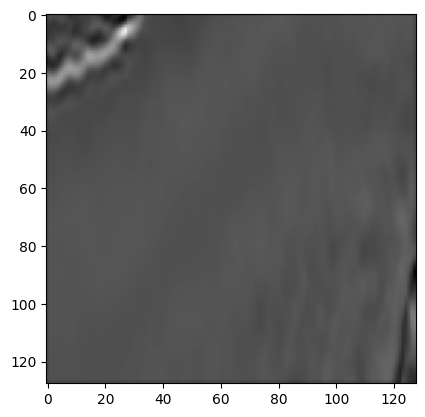

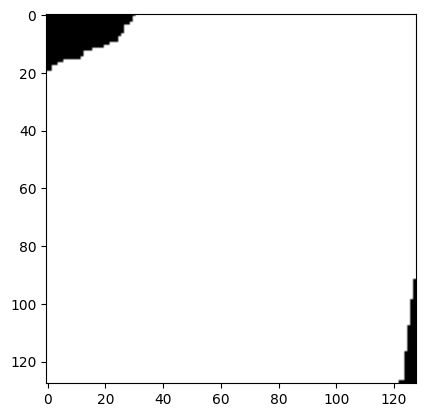

In [12]:
# Check if training data looks all right

ix = random.randint(0, len(train_ids))                              ### This line selects a random index ix, within the range of available training data
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))        ### display the image located at index ix from the X_train array
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)                    ### Corresponding mask located at index ix from the Y_train array is extracted. np.squeeze is used to remove any single-dimensional entries (e.g., turning a (128, 128, 1) array into a (128, 128) array)
plt.imshow(np.dstack((tmp,tmp,tmp)))                                ### This line uses Matplotlib to display the mask. It stacks three copies of the mask side by side to mimic a grayscale image. Visually represent the single-channel mask as a three-channel grayscale image
plt.show()

### Train Model
Evaluated on the mean IoU metric.            
IoU is a common metric used to evaluate the performance of image segmentation models.          
This metric calculates the overlap between the predicted and true regions in an image.                                    

Define IoU metric - taking y_true and y_pred, representing the ground truth (true segmentation mask) and predicted segmentation      
The function iterates over a range of thresholds from 0.5 to 1.0 with a step of 0.05. These thresholds are used to binarize the predicted mask, creating a binary mask for each threshold. 

This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:


The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value.       
The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.         

At each threshold value, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:     

A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold.        
A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold:             

Lastly, the score returned by the competition metric is the mean taken over the individual average precisions of each image in the test dataset.                   

In [13]:
def mean_average_precision(y_true, y_pred, num_thresholds=10):
    precisions = []

    for i in range(num_thresholds):
        threshold = ((i/2) + 4.5) / num_thresholds
        y_pred_bin = tf.cast(y_pred > threshold, dtype=tf.float32)
        true_positives = K.sum(y_true * y_pred_bin)
        false_positives = K.sum((1 - y_true) * y_pred_bin)
        false_negatives = K.sum(y_true * (1 - y_pred_bin))

        precision = true_positives / (true_positives + false_positives + K.epsilon())
        recall = true_positives / (true_positives + false_negatives + K.epsilon())

        average_precision = precision * recall
        precisions.append(average_precision)

    return K.mean(K.stack(precisions), axis=0)

The U-Net: 

In [82]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_average_precision])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 lambda_14 (Lambda)          (None, 128, 128, 1)          0         ['input_15[0][0]']            
                                                                                                  
 conv2d_266 (Conv2D)         (None, 128, 128, 8)          80        ['lambda_14[0][0]']           
                                                                                                  
 conv2d_267 (Conv2D)         (None, 128, 128, 8)          584       ['conv2d_266[0][0]']          
                                                                                           

In [83]:
Y_train.shape

(4000, 128, 128, 1)

##### Fitting the data 

In [149]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-2.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.15, batch_size=16, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/30
213/213 [==============================] - ETA: 0s - loss: 0.2469 - mean_average_precision: 0.5220
Epoch 1: val_loss improved from inf to 0.22973, saving model to model-tgs-salt-2.h5


C:\Users\tanopsgeo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


213/213 [==============================] - 433s 2s/step - loss: 0.2469 - mean_average_precision: 0.5220 - val_loss: 0.2297 - val_mean_average_precision: 0.5345
Epoch 2/30
213/213 [==============================] - ETA: 0s - loss: 0.2372 - mean_average_precision: 0.5342
Epoch 2: val_loss improved from 0.22973 to 0.22851, saving model to model-tgs-salt-2.h5
213/213 [==============================] - 423s 2s/step - loss: 0.2372 - mean_average_precision: 0.5342 - val_loss: 0.2285 - val_mean_average_precision: 0.5420
Epoch 3/30
213/213 [==============================] - ETA: 0s - loss: 0.2350 - mean_average_precision: 0.5346
Epoch 3: val_loss did not improve from 0.22851
213/213 [==============================] - 417s 2s/step - loss: 0.2350 - mean_average_precision: 0.5346 - val_loss: 0.2364 - val_mean_average_precision: 0.5012
Epoch 4/30
213/213 [==============================] - ETA: 0s - loss: 0.2329 - mean_average_precision: 0.5408
Epoch 4: val_loss did not improve from 0.22851
213/213 

#### Model 2 - include Batch Normalisation ......        

In [14]:
from keras.layers import BatchNormalization

In [163]:
# Build U-Net model - with BatchNormalization ... 
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = BatchNormalization() (c1)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
c1 = BatchNormalization() (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = BatchNormalization() (c2)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
c2 = BatchNormalization() (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = BatchNormalization() (c3)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
c3 = BatchNormalization() (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = BatchNormalization() (c4)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
c4 = BatchNormalization() (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = BatchNormalization() (c5)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = BatchNormalization() (c6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = BatchNormalization() (c7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = BatchNormalization() (c8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = BatchNormalization() (c9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_average_precision])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 lambda_16 (Lambda)          (None, 128, 128, 1)          0         ['input_17[0][0]']            
                                                                                                  
 conv2d_286 (Conv2D)         (None, 128, 128, 8)          80        ['lambda_16[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 8)          32        ['conv2d_286[0][0]']          
 Normalization)                                                                            

In [164]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-3.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.15, batch_size=16, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/30
213/213 [==============================] - ETA: 0s - loss: 0.4188 - mean_average_precision: 0.3159
Epoch 1: val_loss improved from inf to 1.96958, saving model to model-tgs-salt-3.h5


C:\Users\tanopsgeo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


213/213 [==============================] - 542s 2s/step - loss: 0.4188 - mean_average_precision: 0.3159 - val_loss: 1.9696 - val_mean_average_precision: 0.2381
Epoch 2/30
213/213 [==============================] - ETA: 0s - loss: 0.3081 - mean_average_precision: 0.4927
Epoch 2: val_loss improved from 1.96958 to 0.68944, saving model to model-tgs-salt-3.h5
213/213 [==============================] - 494s 2s/step - loss: 0.3081 - mean_average_precision: 0.4927 - val_loss: 0.6894 - val_mean_average_precision: 0.3836
Epoch 3/30
213/213 [==============================] - ETA: 0s - loss: 0.2701 - mean_average_precision: 0.5595
Epoch 3: val_loss improved from 0.68944 to 0.42498, saving model to model-tgs-salt-3.h5
213/213 [==============================] - 485s 2s/step - loss: 0.2701 - mean_average_precision: 0.5595 - val_loss: 0.4250 - val_mean_average_precision: 0.5514
Epoch 4/30
213/213 [==============================] - ETA: 0s - loss: 0.2455 - mean_average_precision: 0.6017
Epoch 4: val_l

#### Model 3 - Optimize the Learning Rate 

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [16]:
# Define learning rate scheduler function
def lr_scheduler(epoch):
    return 0.001 * np.exp(-epoch / 10)

# Create the LearningRateScheduler callback
lr_schedule = LearningRateScheduler(lr_scheduler)

In [17]:
# Build U-Net model - with BatchNormalization (v3)
# And learning-rate Scheduler
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = BatchNormalization() (c1)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
c1 = BatchNormalization() (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = BatchNormalization() (c2)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
c2 = BatchNormalization() (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = BatchNormalization() (c3)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
c3 = BatchNormalization() (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = BatchNormalization() (c4)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
c4 = BatchNormalization() (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = BatchNormalization() (c5)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = BatchNormalization() (c6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = BatchNormalization() (c7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = BatchNormalization() (c8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = BatchNormalization() (c9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[mean_average_precision])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 8)          80        ['lambda[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 8)          32        ['conv2d[0][0]']              
 Normalization)                                                                               

In [18]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-4.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.15, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer, lr_schedule])

Epoch 1/30
425/425 [==============================] - ETA: 0s - loss: 0.3975 - mean_average_precision: 0.2680
Epoch 1: val_loss improved from inf to 0.42830, saving model to model-tgs-salt-4.h5


C:\Users\tanopsgeo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


425/425 [==============================] - 539s 1s/step - loss: 0.3975 - mean_average_precision: 0.2680 - val_loss: 0.4283 - val_mean_average_precision: 0.3397 - lr: 0.0010
Epoch 2/30
425/425 [==============================] - ETA: 0s - loss: 0.3116 - mean_average_precision: 0.4761
Epoch 2: val_loss improved from 0.42830 to 0.23942, saving model to model-tgs-salt-4.h5
425/425 [==============================] - 485s 1s/step - loss: 0.3116 - mean_average_precision: 0.4761 - val_loss: 0.2394 - val_mean_average_precision: 0.5786 - lr: 9.0484e-04
Epoch 3/30
425/425 [==============================] - ETA: 0s - loss: 0.2811 - mean_average_precision: 0.5468
Epoch 3: val_loss did not improve from 0.23942
425/425 [==============================] - 506s 1s/step - loss: 0.2811 - mean_average_precision: 0.5468 - val_loss: 0.2749 - val_mean_average_precision: 0.6064 - lr: 8.1873e-04
Epoch 4/30
425/425 [==============================] - ETA: 0s - loss: 0.2545 - mean_average_precision: 0.5925
Epoch 4:

#### Model 5 - improve with extra Deep Convolution layer ....   

In [32]:
# Build U-Net model - with BatchNormalization (v3)
# And learning-rate Scheduler
# Extra deeper conv layer
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = BatchNormalization() (c1)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
c1 = BatchNormalization() (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = BatchNormalization() (c2)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
c2 = BatchNormalization() (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = BatchNormalization() (c3)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
c3 = BatchNormalization() (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = BatchNormalization() (c4)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
c4 = BatchNormalization() (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = BatchNormalization() (c5)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)
# Additional Deeper Convolutional Layer
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)
c5 = BatchNormalization() (c5)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)
c5 = BatchNormalization() (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = BatchNormalization() (c6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = BatchNormalization() (c7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = BatchNormalization() (c8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = BatchNormalization() (c9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[mean_average_precision])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 128, 128, 1)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 8)          80        ['lambda_1[0][0]']            
                                                                                                  
 batch_normalization_13 (Ba  (None, 128, 128, 8)          32        ['conv2d_19[0][0]']           
 tchNormalization)                                                                          

In [33]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-5.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.15, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer, lr_schedule])

Epoch 1/30
425/425 [==============================] - ETA: 0s - loss: 0.4259 - mean_average_precision: 0.2592
Epoch 1: val_loss improved from inf to 1.51802, saving model to model-tgs-salt-5.h5
425/425 [==============================] - 553s 1s/step - loss: 0.4259 - mean_average_precision: 0.2592 - val_loss: 1.5180 - val_mean_average_precision: 0.3063 - lr: 0.0010
Epoch 2/30
425/425 [==============================] - ETA: 0s - loss: 0.3482 - mean_average_precision: 0.4199
Epoch 2: val_loss improved from 1.51802 to 0.28582, saving model to model-tgs-salt-5.h5
425/425 [==============================] - 490s 1s/step - loss: 0.3482 - mean_average_precision: 0.4199 - val_loss: 0.2858 - val_mean_average_precision: 0.4338 - lr: 9.0484e-04
Epoch 3/30
425/425 [==============================] - ETA: 0s - loss: 0.3101 - mean_average_precision: 0.5100
Epoch 3: val_loss improved from 0.28582 to 0.26493, saving model to model-tgs-salt-5.h5
425/425 [==============================] - 577s 1s/step - lo

### Test The Models 
Extract test data 

In [19]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


C:\Users\tanopsgeo\AppData\Local\Temp\ipykernel_20464\2717217732.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):


  0%|          | 0/18000 [00:00<?, ?it/s]

Done!


In [34]:
## Predict on train, val and test
## Model 1 - standard U-net, 
## Model 2 - improved threshold metric, larger validation, batch increased
## Model 3 - added BatchNormalization() 
model = load_model('model-tgs-salt-5.h5', custom_objects={'mean_average_precision': mean_average_precision})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

563/563 [==============================] - 365s 648ms/step


In [35]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

C:\Users\tanopsgeo\AppData\Local\Temp\ipykernel_20464\2557339385.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(preds_test)):


  0%|          | 0/18000 [00:00<?, ?it/s]

In [36]:
preds_test_upsampled[0].shape

(101, 101)

Looking at a random sample 

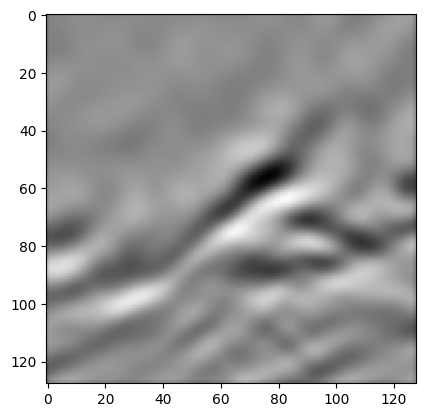

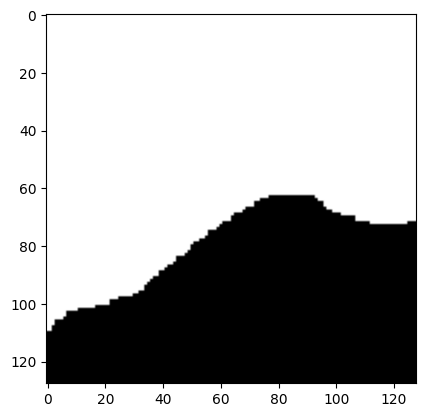

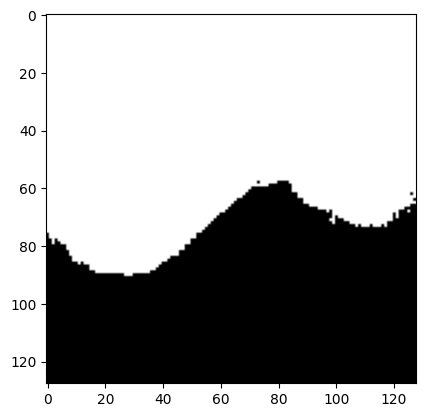

In [42]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

### Prepare the Submission


In [43]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

C:\Users\tanopsgeo\AppData\Local\Temp\ipykernel_20464\2855904262.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}


0it [00:00, ?it/s]

In [44]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission5.csv')